In [1]:
from polygon import RESTClient
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import datetime as dt
import matplotlib.pyplot as plt
import time

In [2]:
client = RESTClient(api_key="G_MMjJtfSRlyGyidOaBYczv6zy8BYlh3")

In [3]:
# Define a function to perform an operation on the named tuple
def timestamp_function(named_tuple):
    
    timestamp = named_tuple.timestamp / 1_000
    dt_object = dt.datetime.utcfromtimestamp(timestamp)    
    formatted_date_time = dt_object.strftime('%Y-%m-%d %H:%M:%S')

    return pd.to_datetime(formatted_date_time)

# get stock data
def get_stock_data(ticker, from_, to, timespan="minute"):
    
    # List Aggregates (Bars)
    stock_data = []
    for a in client.list_aggs(ticker=ticker, multiplier=1, timespan=timespan, from_=from_, to=to, limit=50000):
        stock_data.append(a)
        
    return stock_data

# get the option data
def get_option_data(ticker, strike, from_, to, maturity, C_or_P, timespan="minute"):
    
    option_data = []
    for a in client.list_aggs(f"O:{ticker}{maturity}{C_or_P}{strike}", 1, timespan, from_, to, limit=50000):
        option_data.append(a)
    
    return option_data, int(strike.lstrip('0'))/1_000, pd.to_datetime("20" + maturity)

# get option pricing
N = norm.cdf
def BS_CALL(S, K, T, r, sigma):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)    
    
# get implied volatility calculation
def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
        
# get implied volatility calculation for pandas
def pd_implied_vol(row, r, type_='call'):
    
    option_value = row['option close']
    S = row['stock close']
    K = row['strike']
    T = row['years to maturity']
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - option_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
        
# find the years between the current day and the option maturity
def years_to_maturity(row):
    return (row['maturity'] - row['timestamp']) / pd.Timedelta(days=365.25)

In [4]:
# stock prices
aggs = get_stock_data("AAPL", "2023-01-30", "2023-02-03")
aggs[:5]

[Agg(open=145.54, high=145.54, low=144.01, close=144.02, volume=5452, vwap=144.3761, timestamp=1675069200000, transactions=165, otc=None),
 Agg(open=144.08, high=144.08, low=144, close=144.05, volume=3616, vwap=144.0363, timestamp=1675069260000, transactions=81, otc=None),
 Agg(open=144.03, high=144.04, low=144.01, close=144.01, volume=1671, vwap=144.0353, timestamp=1675069320000, transactions=52, otc=None),
 Agg(open=144.01, high=144.03, low=144, close=144.03, volume=4721, vwap=144.0127, timestamp=1675069380000, transactions=56, otc=None),
 Agg(open=144.02, high=144.02, low=144.02, close=144.02, volume=1343, vwap=144.0219, timestamp=1675069440000, transactions=40, otc=None)]

In [5]:
# create a pandas dataframe of the historical stock data
stock_data = pd.DataFrame({
    'stock close':        [agg.close for agg in aggs],
    'stock volume':       [agg.volume for agg in aggs],
    'stock vwap':         [agg.vwap for agg in aggs],
    'timestamp':          [timestamp_function(agg) for agg in aggs],
    'stock transactions': [agg.transactions for agg in aggs],
    })

# change the index so that it is the timestamp column
stock_data = stock_data.set_index('timestamp')

# Display the DataFrame
stock_data

,stock close,stock volume,stock vwap,stock transactions
timestamp,,,,
2023-01-30 09:00:00,144.0200,5452.0,144.3761,165
2023-01-30 09:01:00,144.0500,3616.0,144.0363,81
2023-01-30 09:02:00,144.0100,1671.0,144.0353,52
2023-01-30 09:03:00,144.0300,4721.0,144.0127,56
2023-01-30 09:04:00,144.0200,1343.0,144.0219,40
...,...,...,...,...
2023-02-04 00:54:00,154.3301,347.0,154.3313,21
2023-02-04 00:55:00,154.3400,1438.0,154.3318,38
2023-02-04 00:56:00,154.3300,588.0,154.3390,17


Below is a single run of the option process

In [ ]:
# get option data
option_aggs = get_option_data("AAPL", strike="00150000", from_="2023-01-30", to="2023-02-03", maturity="251219", C_or_P="C")

# create a pandas dataframe of the option price
option_data = pd.DataFrame({
    'option close':  [agg.close for agg in option_aggs[0]],
    'timestamp':     [timestamp_function(agg) for agg in option_aggs[0]],
    'strike':        [option_aggs[1] for agg in option_aggs[0]],
    'maturity':      [option_aggs[2] for agg in option_aggs[0]]
    })

# Apply the function to create a new column
option_data['years to maturity'] = option_data.apply(years_to_maturity, axis=1)

# change the index so that it is the timestamp column
option_data = option_data.set_index('timestamp')

# merge left on the option dataframe to add stock prices into it
total_data = option_data[['option close', 'strike', 'years to maturity']].merge(stock_data[['stock close']], on='timestamp', how='left', indicator=False)

# add an implied volatility column for the dataframe
total_data['implied volatility'] = total_data.apply(pd_implied_vol, args=(0.05,), axis=1)

Loop of multiple processes to run options at different strike prices and put them together for graphing

In [6]:
# full option data to get implied volatility for multiple strikes
def full_option_process(strike):
    
    option_aggs = get_option_data("AAPL", strike=strike, from_="2023-01-30", to="2023-02-03", maturity="251219", C_or_P="C")
    if len(option_aggs[0]) == 0:
        return pd.DataFrame(columns=['strike', 'implied volatility'])
    else:
        # create a pandas dataframe of the option price
        option_data = pd.DataFrame({
            'option close':  [agg.close for agg in option_aggs[0]],
            'timestamp':     [timestamp_function(agg) for agg in option_aggs[0]],
            'strike':        [option_aggs[1] for agg in option_aggs[0]],
            'maturity':      [option_aggs[2] for agg in option_aggs[0]]
            })

        # Apply the function to create a new column
        option_data['years to maturity'] = option_data.apply(years_to_maturity, axis=1)

        # change the index so that it is the timestamp column
        option_data = option_data.set_index('timestamp')

        # merge left on the option dataframe to add stock prices into it
        total_data = option_data[['option close', 'strike', 'years to maturity']].merge(stock_data[['stock close']], on='timestamp', how='left', indicator=False)

        # add an implied volatility column for the dataframe
        total_data['implied volatility'] = total_data.apply(pd_implied_vol, args=(0.05,), axis=1)
        data_return = pd.DataFrame([total_data[['strike', 'implied volatility']].median()])
      
        return data_return

In [7]:
result_df = pd.DataFrame(columns=['strike', 'implied volatility'])
# example run of the full_option_process function is: strike_150 = full_option_process("00150000")

for i in range(60, 310, 5):
    strike_string = str(i)
    print(f'Running {strike_string}...')
    if len(strike_string) == 2:
        strike_string = '0' + strike_string
    else:
        pass
    strike_string = '00' + strike_string + '000'
    
    # run full option process
    option_run = full_option_process(strike_string)
    result_df = pd.concat([result_df, option_run], ignore_index=True)
    
    time.sleep(15) # can only run 5 calls per minute

print('Runs completed!')
#result_df

Running 60...
Running 65...
Running 70...
Running 75...
Running 80...
Running 85...
Running 90...
Running 95...
Running 100...
Running 105...
Running 110...
Running 115...
Running 120...
Running 125...
Running 130...
Running 135...
Running 140...
Running 145...
Running 150...
Running 155...
Running 160...
Running 165...
Running 170...
Running 175...
Running 180...
Running 185...
Running 190...
Running 195...
Running 200...
Running 205...
Running 210...
Running 215...
Running 220...
Running 225...
Running 230...
Running 235...
Running 240...
Running 245...
Running 250...
Running 255...
Running 260...
Running 265...
Running 270...
Running 275...
Running 280...
Running 285...
Running 290...
Running 295...
Running 300...
Running 305...
Runs completed!


,strike,implied volatility
0,60.0,0.084330
1,65.0,0.051839
2,70.0,0.066608
3,75.0,0.054814
4,80.0,0.051406
5,85.0,0.047297
6,90.0,0.232506
7,95.0,0.227990
8,100.0,0.250282
9,105.0,0.245565


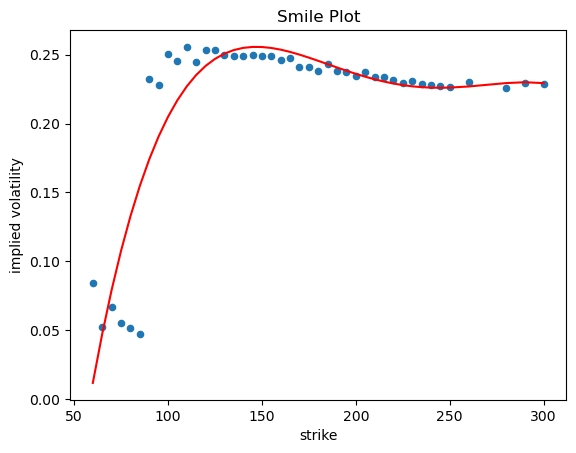

In [37]:
lower_bound = 0
upper_bound = 350
plot_df = result_df[(result_df['strike'] >= lower_bound) & (result_df['strike'] <= upper_bound)].copy()

# Scatter plot
plot_df.plot.scatter(x='strike', y='implied volatility', title='Smile Plot')

# Calculate and plot the trendline (linear regression)
coefficients = np.polyfit(plot_df['strike'], plot_df['implied volatility'], 4)
trendline = np.polyval(coefficients, plot_df['strike'])
plt.plot(plot_df['strike'], trendline, color='red', label='Trendline')

# Show the plot
plt.show()